In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install datasets
!pip install evaluate
!pip install timm
!pip install transformers[torch]
!pip install accelerate

In [14]:
import os
import sys
import re
import gc
import platform
import random
import matplotlib.pyplot as plt #графики
import plotly.express as px #графики
import seaborn as sns #графики


import numpy as np
import pandas as pd #пандас для загрузки датасета
from tqdm import tqdm # красивое отображение циклов

import torch #пайторч
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


from datasets import Dataset # датасет для хаггингфейс
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoModel, BeitForImageClassification # нужно, чтобы качать модели с hf

from sklearn.metrics import roc_auc_score, f1_score # рассчитывать метрики
from sklearn.model_selection import StratifiedKFold, train_test_split
import evaluate  # рассчитывать метрики

import timm # библиотека с нужными моделями
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import glob
import cv2
from PIL import Image

import albumentations as A # аугментации
from albumentations.pytorch import ToTensorV2
from tqdm.contrib import tzip
import warnings
warnings.simplefilter('ignore')

In [15]:
df = pd.read_csv('train.csv', sep=';')
df

,object_id,name,description,group,img_name
0,10669820,Водолей - коник (фрагмент - голова),"сероглиняный, лепной, со сплошным белым ангобо...",Археология,7862029.jpg
1,4489444,Винтовка «Самозарядная винтовка Токарева» (мет...,"На стволе имеется надульник, на торце которог...",Оружие,9461061.jpg
2,8722586,Инструмент. Калибр-скоба,Прямоугольная пластина с усечёнными углами и д...,Прочие,5095122.jpg
3,3712248,"Судомодель. НИС ""Космонавт Виктор Пацаев"".","Корпус модели, надстройки, шлюпки выполнены и...",Прочие,551422.jpg
4,6339754,Сабля.,NaN,Оружие,2592073.jpg
...,...,...,...,...,...
20340,19945381,La Sainte Bible avec des explications & reflex...,"В переплете коричневой кожи, на корешке три н...",Редкие книги,20653985.jpg
20341,10334174,Фрагмент ручки синопской амфоры с сохранившимс...,NaN,Археология,41217662.jpg
20342,4708600,Шашка кавказская.(ножны),NaN,Оружие,1766049.jpg
20343,9622688,Висмутин,Висмутин. Зёрна в кварце,Минералогия,6305416.jpg


In [16]:
name_class = df['group'].unique()
name_class

array(['Археология', 'Оружие', 'Прочие', 'Нумизматика', 'Фото, негативы',
       'Редкие книги', 'Документы', 'Печатная продукция', 'ДПИ',
       'Скульптура', 'Графика', 'Техника', 'Живопись',
       'Естественнонауч.коллекция', 'Минералогия'], dtype=object)

In [17]:
main_path = 'train'

sdict = {name: id for name, id in zip(name_class, range(len(name_class)))}

images = [main_path + '/' + str(object_id) + '/' + str(img_name) for object_id, img_name in zip(df['object_id'], df['img_name'])]
classes = [sdict[i] for i in df['group']]

df = pd.DataFrame(data={
    'img': images,
    'cls': classes
})

df

,img,cls
0,train/10669820/7862029.jpg,0
1,train/4489444/9461061.jpg,1
2,train/8722586/5095122.jpg,2
3,train/3712248/551422.jpg,2
4,train/6339754/2592073.jpg,1
...,...,...
20340,train/19945381/20653985.jpg,5
20341,train/10334174/41217662.jpg,0
20342,train/4708600/1766049.jpg,1
20343,train/9622688/6305416.jpg,14


In [31]:
sdict

{'Археология': 0,
 'Оружие': 1,
 'Прочие': 2,
 'Нумизматика': 3,
 'Фото, негативы': 4,
 'Редкие книги': 5,
 'Документы': 6,
 'Печатная продукция': 7,
 'ДПИ': 8,
 'Скульптура': 9,
 'Графика': 10,
 'Техника': 11,
 'Живопись': 12,
 'Естественнонауч.коллекция': 13,
 'Минералогия': 14}

<Axes: xlabel='cls', ylabel='Count'>

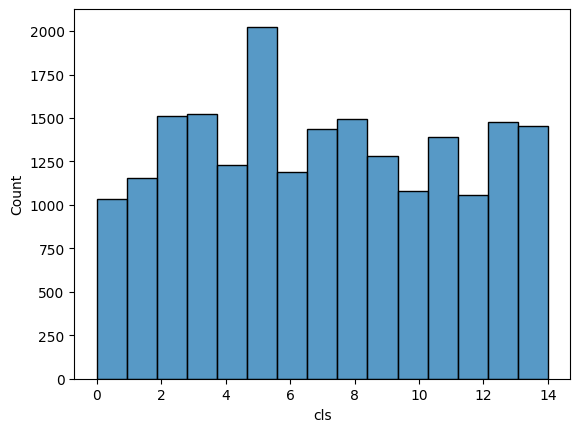

In [18]:
sns.histplot(data=df, x="cls", bins=15)

In [19]:
ds = Dataset.from_pandas(df)
ds = ds.class_encode_column("cls")
ds = ds.train_test_split(test_size=0.1, seed=42, shuffle=True, stratify_by_column='cls')
ds

Stringifying the column:   0%|          | 0/20345 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/20345 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'cls'],
        num_rows: 18310
    })
    test: Dataset({
        features: ['img', 'cls'],
        num_rows: 2035
    })
})

In [32]:
preprocessor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k")
model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=15, ignore_mismatched_sizes=True)
model.to('cuda')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([15, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_featur

In [33]:
for param in model.swinv2.parameters():
    param.requires_grad = False

In [34]:
def auto_transforms(examples):
    images = [Image.open(path).convert("RGB") for path in examples["img"]]
    inputs = preprocessor(images=images, return_tensors="pt")
    inputs['labels'] = torch.tensor(examples['cls'])
    return inputs

In [35]:
ds = ds.with_transform(auto_transforms)

In [36]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [37]:
f1 = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels)

def custom_rmse(act, pred): # функция
    diff = pred - act # находим разницу между прогнозируемыми и наблюдаемыми значениями
    differences_squared = diff ** 2 # возводим в квадрат (чтобы избавиться от отрицательных значений)
    mean_diff = np.sqrt(differences_squared.mean()) # находим среднее значение

    return mean_diff

In [38]:
from transformers import XCLIPProcessor, XCLIPModel # трансформеры
from transformers import TrainingArguments, Trainer # обучение трансформеров
from sklearn.model_selection import KFold # кросс валидация
# from lion_pytorch import Lion # оптимайзер

from mpl_toolkits.axes_grid1 import ImageGrid # КРАСИВОЕ отображение фоток
from glob import glob

training_args = TrainingArguments(
    output_dir="models/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    weight_decay=1e-4,
    per_device_train_batch_size=128,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    logging_steps=10,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
    optim='adamw_torch',
    save_total_limit=1,
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=preprocessor,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/288 [00:00<?, ?it/s]

{'loss': 2.5055, 'grad_norm': 3.6458640098571777, 'learning_rate': 0.0004826388888888889, 'epoch': 0.07}
{'loss': 1.8047, 'grad_norm': 3.4575963020324707, 'learning_rate': 0.0004652777777777778, 'epoch': 0.14}
{'loss': 1.4141, 'grad_norm': 2.807126998901367, 'learning_rate': 0.0004479166666666667, 'epoch': 0.21}
{'loss': 1.1842, 'grad_norm': 2.48751163482666, 'learning_rate': 0.0004305555555555556, 'epoch': 0.28}
{'loss': 1.0417, 'grad_norm': 2.4209983348846436, 'learning_rate': 0.00041319444444444444, 'epoch': 0.35}
{'loss': 1.0097, 'grad_norm': 2.6187310218811035, 'learning_rate': 0.0003958333333333333, 'epoch': 0.42}
{'loss': 0.9044, 'grad_norm': 2.355313539505005, 'learning_rate': 0.0003784722222222222, 'epoch': 0.49}
{'loss': 0.9694, 'grad_norm': 2.910196542739868, 'learning_rate': 0.0003611111111111111, 'epoch': 0.56}
{'loss': 0.9035, 'grad_norm': 2.4179348945617676, 'learning_rate': 0.00034375, 'epoch': 0.62}
{'loss': 0.9199, 'grad_norm': 2.1832337379455566, 'learning_rate': 0.0

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.7468463778495789, 'eval_accuracy': 0.772972972972973, 'eval_runtime': 58.7166, 'eval_samples_per_second': 34.658, 'eval_steps_per_second': 0.272, 'epoch': 1.0}


KeyboardInterrupt: 

In [47]:
#!python main.py

2024-04-14 10:35:06.312517: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 10:35:06.339436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 10:35:06.339482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 10:35:06.340236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 10:35:06.344548: I tensorflow/core/platform/cpu_feature_guar

In [13]:
trainer.save_model('swinv2')

In [ ]:
new_predictions

In [ ]:
probabilities = nn.functional.softmax(torch.tensor(new_predictions.predictions[0:10]), dim=-1)

for i in range(0, 10):
  array = ds['test'][i]['pixel_values'].numpy()

  # Отображение изображений
  fig, axes = plt.subplots(1, len(array), figsize=(10, 5))
  for i in range(len(array)):
      axes[i].imshow(array[i], cmap='gray')
      axes[i].axis('off')
  print(float(max(probabilities)), name_class[probabilities.argmax()])
  plt.show()